In [13]:
# -*- coding: utf-8 -*-
"""routes_with_zips_S3_and_github.ipynb

Automatically generated by Colaboratory.


Original file is located at
    https://colab.research.google.com/drive/1DnLdr4U43hsbE_sbHa1A7Na49P2OFskw
"""

# replacing files on the drive for those on the S3
# S3 link to be used:      s3://finalprojectaustintrash
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import csv
import geopandas as gpd
from shapely.geometry import Polygon, mapping, Point
from rtree import Rtree
import pygeos

Zips:
  geodb_oid objectid zipcodes_i zipcode        name created_by created_da  \
0         3        3         56   78739      AUSTIN                         
1         4        4         57   78645     LEANDER                         
2        16       16         10   78602     BASTROP                         
3        17       17         11   78655  MARTINDALE                         
4        18       18         12   78617   DEL VALLE                         

  modified_b modified_d        shape_area         shape_len cartodb_id  \
0                        338340541.543711  97785.7933337692          3   
1                        1043395959.57919  196654.442799695          4   
2                        5914481887.52673  506803.883036815          9   
3                        1846885535.93133  212904.793002763         10   
4                        1885223526.51104  273994.824301404         11   

                      created_at                     updated_at  \
0  2015-06-07 00:48

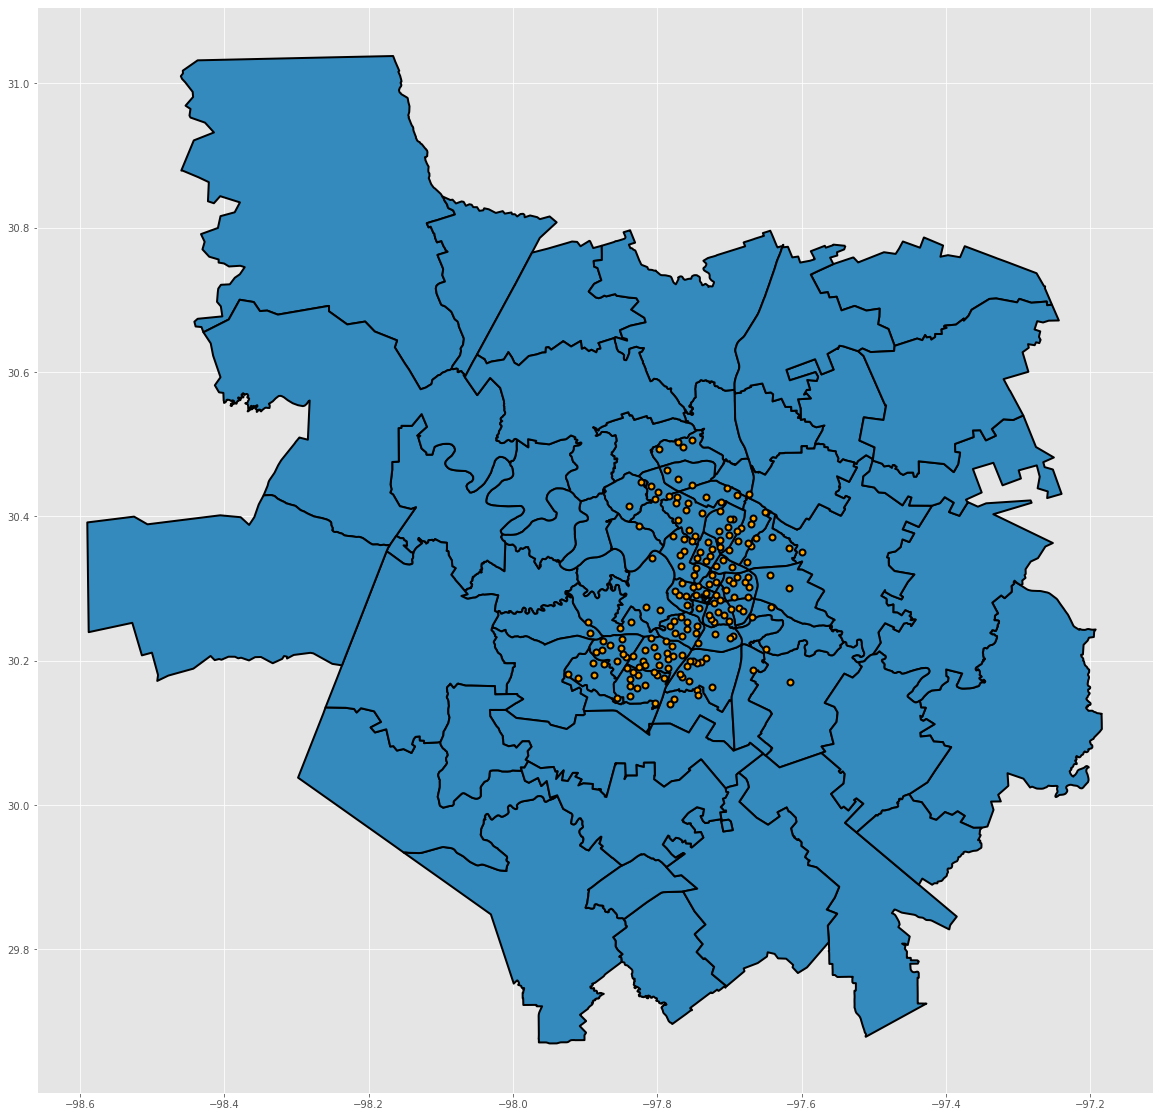

In [14]:
#read the routes file that contains one point per route
routes = pd.read_csv("Routes_Tableau.csv")

routes.head()

#routes to dataframe
routes_df = gpd.GeoDataFrame(routes, geometry=gpd.points_from_xy(routes["Longitude (generated)"], routes["Latitude (generated)"]))




# check file location and create base directory variable
# base_dir will be a list with a single list item, but we need it to be a string
# so we'll just grab the first index
#base_dir = !pwd
#!pwd
#type(base_dir[0])

# use base directory and filename to create the geopandas dataframe
zips = gpd.read_file(f"austin_area_zip_codes.csv",GEOM_POSSIBLE_NAMES="the_geom", KEEP_GEOM_COLUMNS="NO")
print("Zips:")
print(zips.head())

# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 20)

fig, ax = plt.subplots()

zips.geometry.plot(color=None, edgecolor='k',linewidth = 2,ax=ax)
routes_df.geometry.plot(color='Orange', edgecolor='k',linewidth = 2,ax=ax)

zip_coords = zips[['zipcode','geometry']]

route_coords = routes_df[['Garb Rt','geometry']]

zip_coords

route_coords

route_coords.dtypes

# This cycles through all of the route coords and prints the coords with the zip code. Next step, change the print to a return, and then apply it to a new zip column in the route_df. 
#DICT TO CONTAIN POINT AND ZIP
point_and_route = {"point":[], "zip":[]};
for j in route_coords['geometry']:
    idx = 0
    found = 0
    while (found == 0):
        if Point(j).within(zip_coords['geometry'][idx]) or Point(j).intersects(zip_coords['geometry'][idx]):
            point_and_route["point"].append(str(j))
            point_and_route["zip"].append(str(zip_coords['zipcode'][idx]))
            found = 1
        else:
            idx += 1

route_coords["POINT"] = point_and_route["point"]

route_coords["ZIP"] = point_and_route["zip"]

route_coords

# Import df_2017_routes (from waste_data_etl and on S3)
df_2017_routes = pd.read_csv("routes_2017_weight.csv")
print("2017 Routes Dataframe")
print(df_2017_routes.head())

#Merge route_cords and df_2017_routes (from waste_data_etl and on S3) on Garb Rt AND route_number to have the weight added to the first or the zip to the second

# confirm there is only one zip code per route (there are multiple routes per zipcode)

# list the routes per zip i.e for zip 78754 routes are PW41,PW32 and PW30 AND sum the weight per zipcode like groupby.(ZIP).su

# Import full_zip_codes table
df_full_zip_codes = pd.read_csv("full_zip_codes.csv")
print("DF Full Zip Codes")
print(df_full_zip_codes.head())

# Add (merge or append?) the weight per zip code to the full_zip_codes table. AND the if possible add the list of routes per zipcode
#df_zipcodes_housing_grb.head()

#Drop na
#df_zipcodes_housing_grb = df_zipcodes_housing_grb.dropna()
#df_zipcodes_housing_grb.head()

# Export final table the one to feed the model (full_zip_codes table PLUS weight and if possible routes)
# Can we export it directly to S3?
#df_zipcodes_housing_grb.to_csv("Austin_zipcodes_housing_grb.csv")

# This cycles through all of the route coords and prints the coords with the zip code. Next step, change the print to a return, and then apply it to a new zip column in the route_df. 

for j in route_coords['geometry']:
  idx = 0 
  found = 0
  while (found == 0):
    
      if Point(j).within(zip_coords['geometry'][idx]) or Point(j).intersects(zip_coords['geometry'][idx]):
        #print("Route coordinate " + str(j) + " is within " + str(zip_coords['zipcode'][idx]))
        found = 1
      else:
        idx += 1

# We need this part because it needs to go through each polygon to check the route points
  # for each row in zip_coords, is coord in that row's polygon?
  #return current_row["zipcode"]

#def find_zipcode(row): 
#    try:
#      coord = route_coord["geometry"]
#      # if find_within_zipcode returns something, return that value from this function
#      # else, return null value
#      if coord.within(zip_coords['geometry'][row.index]) or coord.intersects(zip_coords['geometry'][row.index]):
#        return zip_coords["zipcode"][row.index]
#    except:
#      return "00000"

# This is to tinker with to see if we can get it to work.
# idx = 0
# for j in route_coords["geometry"].values:
#     try:
#       if Point(j).within(zip_coords['geometry'][idx]) or Point(j).intersects(zip_coords['geometry'][idx]):
#         routes_coords.append(j, zip_coords['zipcode'][idx])
#     except:
#       pass
#     idx+=1

#route_coords["zip"] = route_coords.apply(
#    lambda row: find_zipcode(row), axis=1)
print(route_coords)

#taken from https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html#pandas.DataFrame.join
#using example halfway down page with 'key_A' = 'Garb Rt' and 'key_B' = 'route_number', df_example = "route_coords" and df_other = "df_2017_routes"
print("\n"*10 +"Joined Dataframes")
df_routes_zips = route_coords.join(df_2017_routes.set_index('route_number'),on='Garb Rt')
df_routes_zips= df_routes_zips[["Garb Rt","ZIP","load_weight"]]
print(df_routes_zips.head())
df_full_zip_codes['ZIPCODE'] = df_full_zip_codes['ZIPCODE'].astype(str)
df_routes_zips['ZIP'] = df_routes_zips['ZIP'].astype(str)
df_routes_zips_demographics = df_routes_zips.join(df_full_zip_codes.set_index('ZIPCODE'),on='ZIP')
print("\n"*10 +"Joined Dataframes (routes - zips - demographics)")
print(df_routes_zips_demographics.sort_values(by=['ZIP']).head(15))
#Using mean to perform group by without affecting median income, average income, total_housing units, etc
df_zips_demographics = df_routes_zips_demographics.set_index("ZIP").groupby(level="ZIP").mean()
#using sum to get the entire load weight in each zip code
df_zips_demographics['load_weight'] = df_routes_zips_demographics.set_index("ZIP").groupby(level="ZIP").sum()['load_weight']
print(df_zips_demographics.sort_values(by=['ZIP']).head(10))

df_zips_demographics.to_csv("zips_load_demographics.csv")